In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
%%capture
# english checking
!pip install googletrans==3.1.0a0

# unicode
!pip install unidecode

# vncorenlp
!pip install vncorenlp
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr

!mkdir -p vncorenlp/models/wordsegmenter

!mkdir -p vncorenlp/models/wordsegmenter
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# vietnamese stopword
!wget https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

In [4]:
import pandas as pd
import numpy as np
import re
from itertools import chain

from unidecode import unidecode
from vncorenlp import VnCoreNLP
from googletrans import Translator

In [5]:
# raw
DATA_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/raw_data_2.csv'

# processed & splits path
VI_DATA_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/vn.csv'

FULL_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/full.csv'
TRAIN_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/train.csv'
VAL_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/val.csv'
TEST_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/test.csv'

# all labels
ALL_LABELS_PATH = '/content/drive/MyDrive/Public/DS102 - Machine Learning/data/labels.csv'

# vietnamese stopwords
STOPWORDS_PATH = 'vietnamese-stopwords.txt'

# Load Data

In [ ]:
df = pd.read_csv(DATA_PATH)

In [ ]:
df.columns

Index(['description', 'requirements', 'mapped_industry', 'industry'], dtype='object')

In [ ]:
df.shape

(40097, 4)

In [ ]:
df.sample(5)

,description,requirements,mapped_industry,industry
10594,- Là đại diện của Công ty BHNT Manulife Vietna...,"- Nam/Nữ, tuổi từ 20-35 - Tốt nghiệp Cao đẳng ...","Ngân hàng, Bảo hiểm","33, 6"
14928,"Có kiến thức về chạy quảng cáo facebook, googl...",Có khả năng xử lý vấn đề của quảng cáo Facebo...,Marketing,30
23894,Tham mưu cho Tổng Giám Đốc Công ty trong lĩnh ...,Yêu cầu ứng viên\n 1. Trình độ học vấn: Đại họ...,"Ngân hàng, Quản lý điều hành","33, 10"
13263,"- Tìm kiếm và phát triển khách hàng cá nhân, d...",- Trình độ: Tối thiểu cao đẳng khối ngành Kinh...,"Tư vấn, Ngân hàng, Bảo hiểm","52, 33, 6"
17882,- Tư vấn bán hàng nội thất. - Làm việc theo ca...,- Độ tuổi từ 18-25\n - Có kinh nghiệm ít nhất ...,"Kinh doanh, Kiến trúc - Thiết kế nội thất","26, 27"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40097 entries, 0 to 40096
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   description      40096 non-null  object
 1   requirements     40096 non-null  object
 2   mapped_industry  40097 non-null  object
 3   industry         40097 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


In [ ]:
df[df.description.isnull()]

,description,requirements,mapped_industry,industry
34941,NaN,NaN,"Bán buôn - Bán lẻ - Quản lý cửa hàng, IT Phần ...","5, 21, 30"


In [ ]:
df = df[df.description.notnull()]
df.shape

(40096, 4)

# Tiền xử lý dữ liệu
<!-- - Xóa tất cả các dòng tiếng Anh -->
- Lower case
- Xóa các ký tự đặc biệt (punctuation): #, , & *, $,...
- Tokenization: VnNLPCore
- Xóa các vietnamese stopwords

## Xóa tất cả các dòng chỉ có tiếng Anh

In [ ]:
detector = Translator()

def is_vietnamese(text):
    dec_lan = detector.detect(text)
    return dec_lan.lang == 'vi'

vi_indices = df['description'].apply(is_vietnamese)

In [ ]:
vi_df = df[vi_indices]

In [ ]:
vi_df.shape, vi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34255 entries, 0 to 34254
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   description      34255 non-null  object
 1   requirements     34255 non-null  object
 2   mapped_industry  34255 non-null  object
 3   industry         34255 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


((34255, 4), None)

In [ ]:
# save
vi_df = vi_df.reset_index().drop('index', axis=1)
vi_df.to_csv(VI_DATA_PATH, index=False)

In [6]:
# load
vi_df = pd.read_csv(VI_DATA_PATH)

## Lower case, xóa ký tự đặc biệt, xóa stopword

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
# vi-stopwords
with open(STOPWORDS_PATH, 'r') as file:
    stopwords = file.readlines()
stopwords = [sw.strip() for sw in stopwords if sw.strip()]

In [ ]:
# Check if element is word and '.' or not
def is_word(element):
    if element == '.':
        return True
    pattern = r'^\w+$'
    return re.match(pattern, element) is not None

# Punctuation & stopwords removal
def remove_characters(tokens):
    cleaned_tokens = []
    for token in tokens:
        if token not in stopwords and is_word(unidecode(token)):
                cleaned_tokens.append(token)
    return cleaned_tokens

def preprocess(txt):
    # Lower case
    txt = txt.lower()
    # Tokenization
    txt = vncorenlp.tokenize(txt)
    txt = list(chain.from_iterable(txt))
    # Punctuation & stopwords removal
    txt = remove_characters(txt)
    txt = list(filter(lambda x: x != '', txt))
    # Join
    txt = ' '.join(txt)
    txt = txt.replace('_', ' ')
    txt = txt.replace(' . ', '. ')
    return txt

In [ ]:
vi_df.description = vi_df.description.map(preprocess)
vi_df.requirements = vi_df.requirements.fillna('').map(preprocess)

In [ ]:
full = vi_df

In [ ]:
# save
full.to_csv(FULL_PATH, index=False)

In [7]:
# load
full = pd.read_csv(FULL_PATH)

## Unique job labels

In [11]:
all_labels = full['mapped_industry'].str.cat(sep=', ')
all_labels = list(set(all_labels.split(", ")))
num_labels = len(all_labels)
print('Số lượng nhãn: ', num_labels, ' ngành nghề')

Số lượng nhãn:  72  ngành nghề


In [18]:
all_labels_df = pd.DataFrame(all_labels)

In [19]:
# save
all_labels_df.to_csv(ALL_LABELS_PATH, index=False)

## Change ',' to '/'

In [20]:
full['mapped_industry'] = full['mapped_industry'].map(lambda x: x.replace(', ', ' / '))

## Train, dev, test
* Train: 0.7
* Dev: 0.2
* Test: 0.1

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, val = train_test_split(full, test_size=0.3, random_state=42)
val, test = train_test_split(val, test_size=1-0.66667, random_state=42)

In [ ]:
train.shape, val.shape, test.shape

((23978, 4), (6851, 4), (3426, 4))

In [ ]:
train.shape[0] / len(full), val.shape[0] / len(full), test.shape[0] / len(full)

(0.6999854035907167, 0.2, 0.10001459640928331)

In [ ]:
# save
train.to_csv(TRAIN_PATH, index=False)
val.to_csv(VAL_PATH, index=False)
test.to_csv(TEST_PATH, index=False)

# Visulization

## Số lần xuất hiện của các nhãn

### Barplot

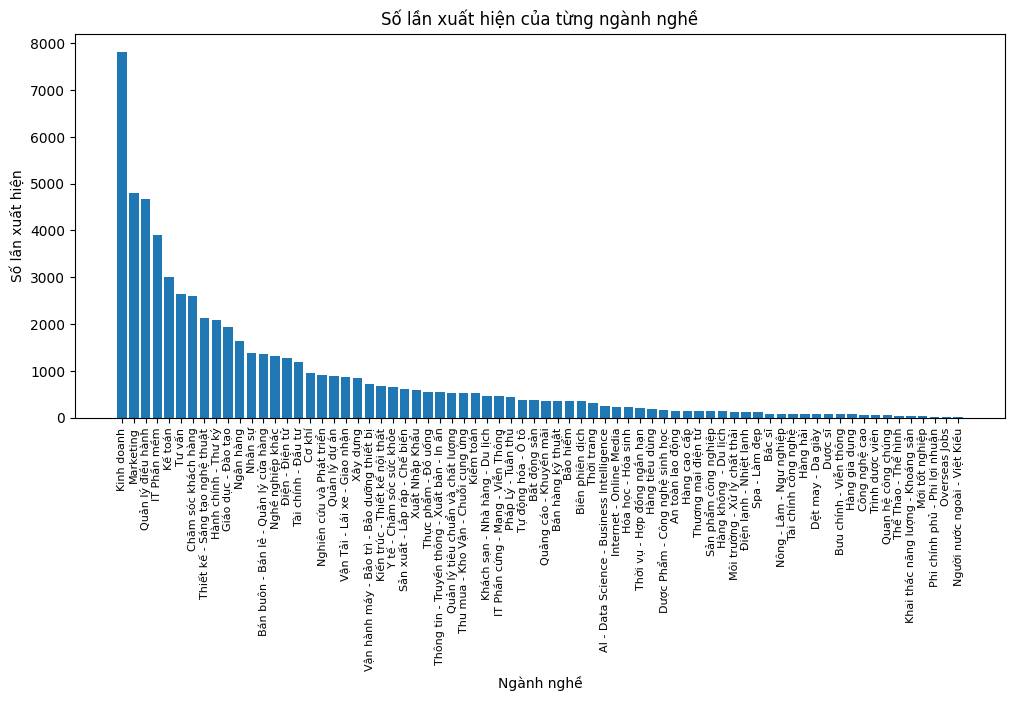

In [106]:
flattened_data = full.mapped_industry.map(lambda x: x.split(' / ')).explode()
value_counts = flattened_data.value_counts()

plt.figure(figsize=(12, 8))

plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Ngành nghề')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Số lần xuất hiện')
plt.title('Số lần xuất hiện của từng ngành nghề')

plt.subplots_adjust(bottom=0.4)

# Save the plot as an image file
plt.savefig('/content/drive/MyDrive/Public/DS102 - Machine Learning/imgs/appearance_each_label.png', dpi=300)

plt.show()

### Wordmap

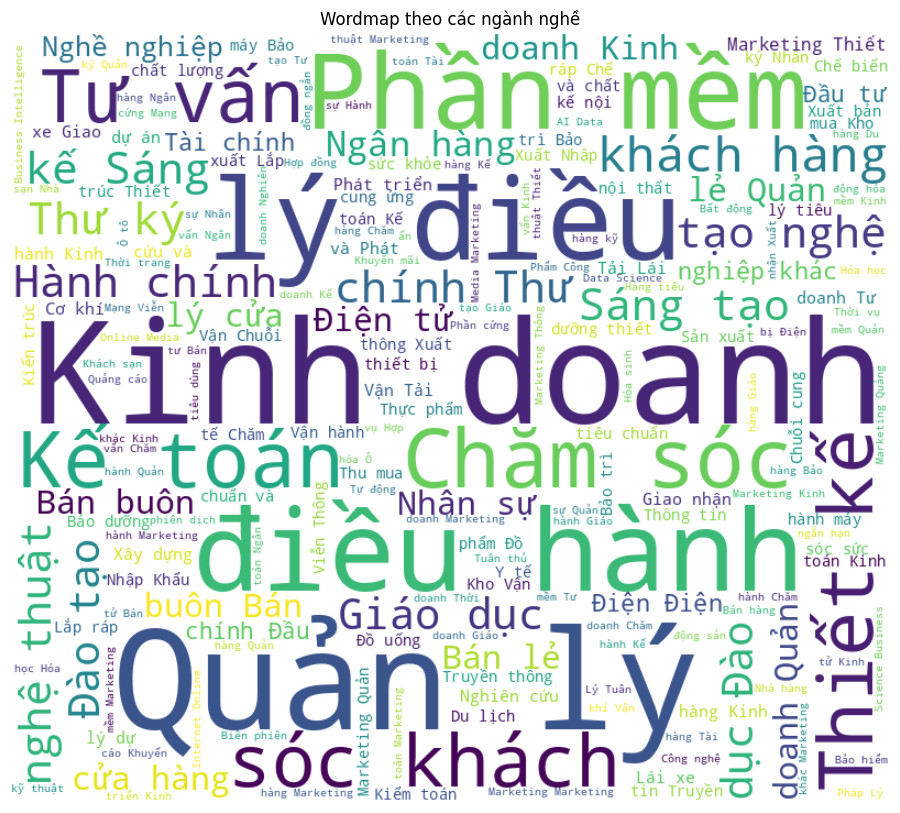

In [107]:
from wordcloud import WordCloud

data = full.mapped_industry.map(lambda x: x.split(' / '))

# Concatenate all lists into a single string
text = ' '.join([word for sublist in data for word in sublist])

# Create a Wordcloud object
wordcloud = WordCloud(width=800, height=700, background_color='white').generate(text)

# Plot the Wordcloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordmap theo các ngành nghề')

# Save the plot as an image file
plt.savefig('/content/drive/MyDrive/Public/DS102 - Machine Learning/imgs/wordmap_label.png', dpi=300, bbox_inches='tight')

plt.show()

## Số lượng sample của Train, Dev và Test

In [111]:
train = pd.read_csv('/content/drive/MyDrive/Public/DS102 - Machine Learning/data/train.csv')
val = pd.read_csv('/content/drive/MyDrive/Public/DS102 - Machine Learning/data/val.csv')
test = pd.read_csv('/content/drive/MyDrive/Public/DS102 - Machine Learning/data/test.csv')

In [113]:
train.shape, val.shape, test.shape

((23978, 4), (6851, 4), (3426, 4))

## Maxlen, Minlen, Avglen từng tập

In [114]:
def txt_len(txt):
    txt = txt.split(' ')
    return len(txt)

In [115]:
train['information'] = train['description'] + ' ' + train['requirements'].fillna('')
val['information'] = val['description'] + ' ' + val['requirements'].fillna('')
test['information'] = test['description'] + ' ' + test['requirements'].fillna('')

In [116]:
train_len = [txt_len(txt) for txt in train['information'].tolist()]
val_len = [txt_len(txt) for txt in val['information'].tolist()]
test_len = [txt_len(txt) for txt in test['information'].tolist()]

In [117]:
# Train
print('Max_len of Train: ', max(train_len))
print('Min_len of Train: ', min(train_len))
print('Avg_len of Train: ', np.mean(train_len))
print()

# Dev
print('Max_len of Dev: ', max(val_len))
print('Min_len of Dev: ', min(val_len))
print('Avg_len of Dev: ', np.mean(val_len))
print()

# Train
print('Max_len of Test: ', max(test_len))
print('Min_len of Test: ', min(test_len))
print('Avg_len of Test: ', np.mean(test_len))
print()

Max_len of Train:  1460
Min_len of Train:  20
Avg_len of Train:  187.69363583284678

Max_len of Dev:  1520
Min_len of Dev:  22
Avg_len of Dev:  185.61509268719894

Max_len of Test:  1513
Min_len of Test:  20
Avg_len of Test:  190.26036193812027



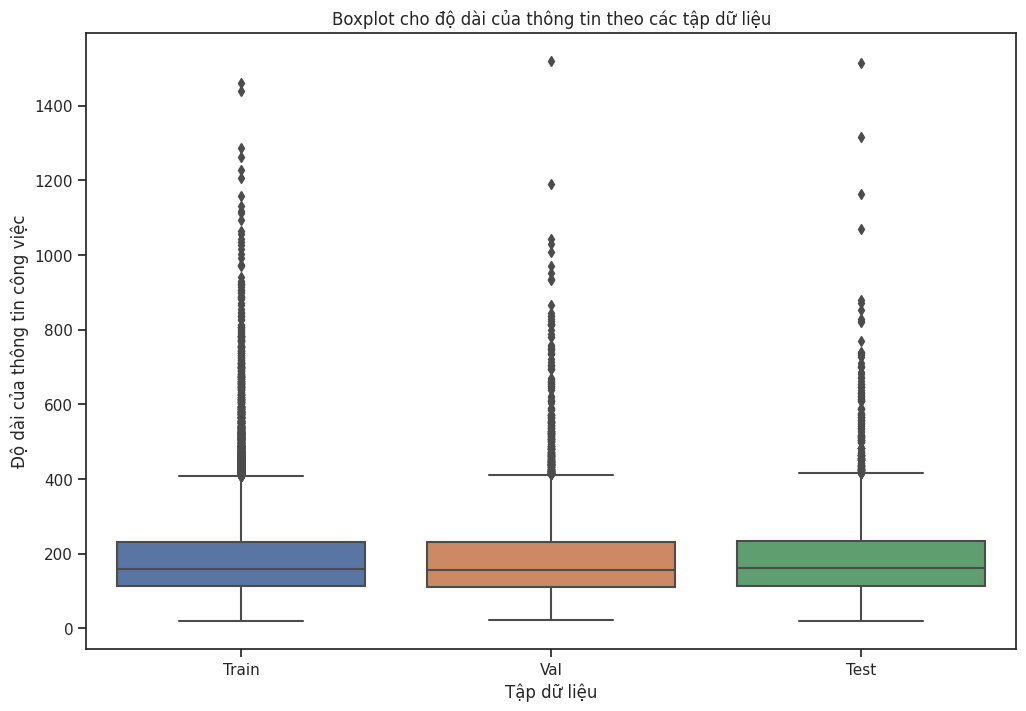

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
plt.figure(figsize=(12, 8))
sns.boxplot(data=[train_len, val_len, test_len], orient="v")
plt.xlabel('Tập dữ liệu')
plt.ylabel('Độ dài của thông tin công việc')
plt.title('Boxplot cho độ dài của thông tin theo các tập dữ liệu')
plt.xticks(ticks=[0, 1, 2], labels=['Train', 'Val', 'Test'])

# Save the plot as an image file
plt.savefig('/content/drive/MyDrive/Public/DS102 - Machine Learning/imgs/boxplot_forlen.png')

# Show the plot
plt.show()

## Số lượng label từ sample

In [ ]:
def count_label(label):
    label = label.split(' / ')
    return len(label)

In [ ]:
train_count_label = pd.Series([count_label(l) for l in train['mapped_industry'].tolist()])
val_count_label = pd.Series([count_label(l) for l in val['mapped_industry'].tolist()])
test_count_label = pd.Series([count_label(l) for l in test['mapped_industry'].tolist()])

In [ ]:
count_label = pd.DataFrame({
    'train': train_count_label.value_counts(),
    'val': val_count_label.value_counts(),
    'test': test_count_label.value_counts(),
})
count_label.fillna(0, inplace=True)

In [ ]:
count_label

,train,val,test
1,11147,3115.0,1583.0
2,7391,2154.0,1039.0
3,5030,1462.0,744.0
4,339,100.0,51.0
5,60,19.0,8.0
6,8,1.0,1.0
7,1,0.0,0.0
8,2,0.0,0.0


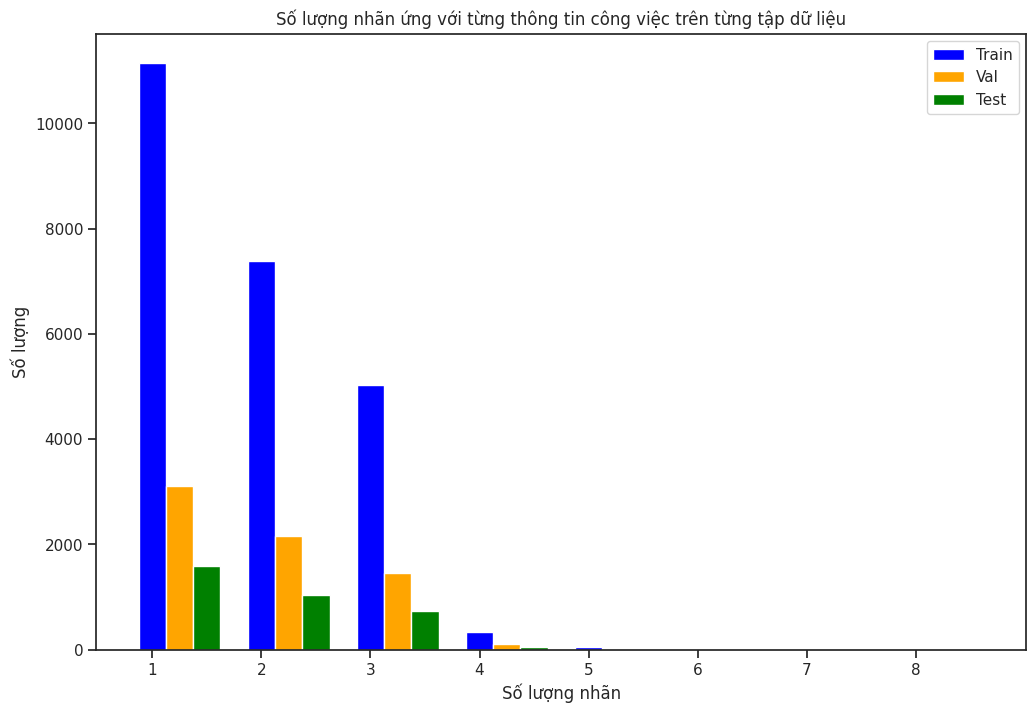

In [ ]:
# Data
data = {
    'train': [11147, 7391, 5030, 339, 60, 8, 1, 2],
    'val': [3115.0, 2154.0, 1462.0, 100.0, 19.0, 1.0, 0.0, 0.0],
    'test': [1583.0, 1039.0, 744.0, 51.0, 8.0, 1.0, 0.0, 0.0]
}

# Set the categories and their positions
categories = ['1', '2', '3', '4', '5', '6', '7', '8']
positions = np.arange(len(categories))

# Set the colors for each group
colors = ['blue', 'orange', 'green']

# Plot the grouped bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.25

for i, col in enumerate(data.keys()):
    ax.bar(positions + i * bar_width, data[col], width=bar_width, color=colors[i], align='center', label=col)

# Customize the plot
ax.set_xticks(positions)
ax.set_xticklabels(categories)
ax.set_xlabel('Số lượng nhãn')
ax.set_ylabel('Số lượng')
ax.set_title('Số lượng nhãn ứng với từng thông tin công việc trên từng tập dữ liệu')
ax.legend(labels=['Train', 'Val', 'Test'])

plt.savefig('/content/drive/MyDrive/Public/DS102 - Machine Learning/imgs/barplot_for_labels.png')

# Show the plot
plt.show()
